In [1]:
# !pip install ggplot

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ['NVIDIA_VISIBLE_DEVICES'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
os.environ

environ{'PATH': '/opt/conda/bin:/opt/conda/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin',
        'HOSTNAME': 'f9e6c529b843',
        'TERM': 'xterm-color',
        'NVIDIA_VISIBLE_DEVICES': '1',
        'CUDA_VERSION': '9.0.176',
        'CUDA_PKG_VERSION': '9-0=9.0.176-1',
        'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64',
        'NVIDIA_DRIVER_CAPABILITIES': 'compute,utility',
        'NVIDIA_REQUIRE_CUDA': 'cuda>=9.0',
        'NCCL_VERSION': '2.4.2',
        'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs',
        'CUDNN_VERSION': '7.4.2.24',
        'LANG': 'C.UTF-8',
        'HOME': '/root',
        'JPY_PARENT_PID': '6',
        'CLICOLOR': '1',
        'PAGER': 'cat',
        'GIT_PAGER': 'cat',
        'MPLBACKEND': 'module://ipykernel.pylab.backend_inline',
        'CUDA_VISIBLE_DEVICES': '1'}

In [4]:
import tensorflow as tf
import numpy as np
import math
from common.losses import get_dist_mtx_xy
import matplotlib.pyplot as plt
import time

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [1255]:
flags = dotdict({})
flags.cross_class_decay = 0.1
flags.cross_class_num_clusters = 50
batch_size = 8
num_features = 128

features_modality1_np = np.random.normal(0, 1, size=(batch_size, num_features))
features_modality2_np = np.random.normal(0, 1, size=(batch_size, num_features))

tf.reset_default_graph()

with tf.Session() as sess:
    with tf.variable_scope("SOM", reuse=tf.AUTO_REUSE):
        
        class_prototypes = tf.get_variable(name='class_prototypes', 
                                           shape=(flags.cross_class_num_clusters, num_features), 
                                           dtype=tf.float32, trainable=False, regularizer=None,
                                           initializer=tf.initializers.random_uniform(maxval=1))

        features_modality1 = tf.placeholder(shape=(batch_size, num_features), dtype=tf.float32)
        features_modality2 = tf.placeholder(shape=(batch_size, num_features), dtype=tf.float32)
        
#         features_modality1 = tf.Variable(features_modality1_np, dtype=tf.float32, trainable=False)
#         features_modality2 = tf.Variable(features_modality2_np, dtype=tf.float32, trainable=False)

        # Concatenate text and image modalities
        d_samples = features_modality1
#         tf.concat([features_modality1, features_modality2], axis=0)
        # For each sample in the data batch, find the best matching prototype
        sample_prototype_distances = get_dist_mtx_xy(d_samples, tf.transpose(class_prototypes))
        # This is the indexes of class prototypes best matching to a given data point
        bmu_idxs = tf.argmax(sample_prototype_distances, axis=-1, output_type=tf.int32)
        # This is the indexes of data points best matching to a given  class prototype
        bm_data_idxs = tf.argmax(sample_prototype_distances, axis=0, output_type=tf.int32)
        data_idx_range = tf.range(tf.shape(d_samples)[0])
        # This is the set of BMUs
        bmus = tf.gather(class_prototypes, bmu_idxs)
#         # This is the truth table showing true when a given datapoint is the closest to a BMU 
#         best_data_point_conditon = tf.equal(tf.gather(bm_data_idxs, bmu_idxs), data_idx_range)
#         # Only those BMUs in bmus have non-zero update that correspond to the closest data point
#         data_minus_bmu = (1 - flags.cross_class_decay) * (d_samples - bmus)
#         bmus_update = tf.where(best_data_point_conditon, 
#                                x=data_minus_bmu, y=tf.zeros_like(d_samples), name="select_bmu_update")
        data_minus_bmu = (1 - flags.cross_class_decay) * (d_samples - bmus)
        bmu_idxs_unique, bmu_idxs_position, bmu_idxs_unique_count = tf.unique_with_counts(bmu_idxs)
        bmu_inverse_weights = tf.gather(bmu_idxs_unique_count, bmu_idxs_position)
        # Divide by the number of data points per BMU
        bmus_update = tf.div(data_minus_bmu, tf.cast(bmu_inverse_weights[:,None], tf.float32))
        
#         class_prototypes = tf.scatter_add(class_prototypes, bmu_idxs, bmus_update, name="implement_bmu_update")
    
        with tf.control_dependencies([bmus_update]):
#             class_prototypes = tf.scatter_add(class_prototypes, bmu_idxs, bmus_update, name="implement_bmu_update")
        
            class_prototypes = tf.scatter_add(class_prototypes, bmu_idxs, data_minus_bmu, name="implement_bmu_update")
        
        sess.run(tf.global_variables_initializer())
        
#         print("BMU indexes", bmu_idxs.eval())
#         print("BMUs unique", bmu_idxs_unique.eval())
#         print("BMU position in batch", bmu_idxs_position.eval())
#         print("BMU count", bmu_idxs_unique_count.eval())
#         print(bmu_inverse_weights.eval())

        print(tf.get_collection(tf.GraphKeys.UPDATE_OPS))
        
        
        for i in range(1000):
            gaussian_zero_mean = 10*np.random.randint(0, 10, size=(batch_size,1)) + np.random.normal(0, 1, size=(batch_size, num_features))
            gaussian_unity_mean = 10*np.random.randint(0, 10, size=(batch_size,1)) + np.random.normal(0, 1, size=(batch_size, num_features))
            
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                class_prototypes_np, bmu_idxs_np = \
                    sess.run([class_prototypes, bmu_idxs], 
                         {features_modality1: gaussian_zero_mean, features_modality2: gaussian_unity_mean})
        
        
#         for i in range(10):
#             gaussian_zero_mean = np.random.randint(0, 2, size=(batch_size,1)) * np.random.normal(1, 0.1, size=(batch_size, num_features))
#             gaussian_unity_mean = np.random.randint(0, 2, size=(batch_size,1)) * np.random.normal(1, 0.1, size=(batch_size, num_features))
            
#             with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#                 class_prototypes_np, best_data_point_conditon_np, bmu_idxs_np = \
#                     sess.run([class_prototypes, best_data_point_conditon, bmu_idxs], 
#                          {features_modality1: gaussian_zero_mean, features_modality2: gaussian_unity_mean})
            
#             print(bmu_idxs_np)
            
#             class_prototypes_np, bmus_update_np = output
            
#         print(bmu_idxs)
#         print(bm_data_idxs)
#         print("BMU index", bmu_idxs.eval())
#         print("Data point of prototype", bm_data_idxs.eval())
#         print(tf.gather(bm_data_idxs, bmu_idxs).eval())
#         print(best_data_point_conditon.eval())
#         print(bmus_update.eval())
#         print(class_prototypes.eval())
        
#         class_prototypes_np = class_prototypes.eval()
#         bmus_update_np = bmus_update.eval()


[]


In [1256]:
prototypes = class_prototypes_np.mean(axis=-1)
prototypes.sort()
prototypes
# class_prototypes_np.std(axis=-1)
# print(set(bmu_idxs_np))
# print(sum(best_data_point_conditon_np))
# gaussian_zero_mean
# class_prototypes_np.std(axis=-1)

# class_prototypes_np[8].std()
# gaussian_zero_mean.mean(axis=-1)

array([ -1.21079931e+01,  -9.12771034e+00,  -3.69587481e-01,
        -2.69480765e-01,  -2.33554855e-01,  -2.03873113e-01,
        -1.40792638e-01,  -8.22070166e-02,  -5.31807840e-02,
        -4.93473411e-02,  -4.47861776e-02,  -6.35468215e-03,
        -1.94888562e-03,   2.99100652e-02,   3.59277129e-02,
         3.76054272e-02,   4.95842546e-02,   5.55817187e-02,
         5.70134372e-02,   7.99832270e-02,   2.19804198e-01,
         3.86118323e-01,   9.94368172e+00,   2.00735397e+01,
         3.01695728e+01,   3.81871948e+01,   3.98470078e+01,
         5.02873840e+01,   5.80153351e+01,   6.00946960e+01,
         6.03919792e+01,   6.10803604e+01,   6.95236359e+01,
         7.88123169e+01,   1.13237328e+02,   1.22951920e+02,
         1.34737778e+02,   1.51599518e+02,   1.56918747e+02,
         1.66736572e+02,   2.03953201e+02,   2.21746887e+02,
         2.22525848e+02,   2.49867371e+02,   2.58342285e+02,
         3.04073730e+02,   3.12141968e+02,   3.84390442e+02,
         4.19591309e+02,

In [1251]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=3000)
tsne_results = tsne.fit_transform(class_prototypes_np)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 2.558512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.632568
[t-SNE] KL divergence after 2200 iterations: 0.795429
t-SNE done! Time elapsed: 0.5451910495758057 seconds


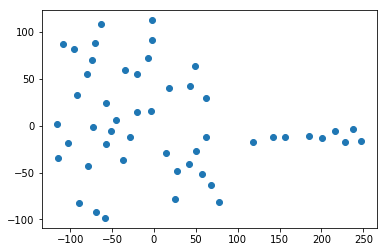

In [1252]:
# import pandas as pd

# df_tsne = pd.DataFrame()
# df_tsne['x-tsne'] = tsne_results[:,0]
# df_tsne['y-tsne'] = tsne_results[:,1]

plt.scatter(tsne_results[:,0], tsne_results[:,1])

In [625]:
d_samples_np = np.concatenate([features_modality1_np, features_modality2_np], axis=0)

sample_prototype_distances_np = -np.sum(
    np.square(np.expand_dims(d_samples_np, -1) - class_prototypes_np.transpose()), axis=1)

bmu_idxs_np = np.argmax(sample_prototype_distances_np, axis=-1)
# This is the indexes of data points best matching to a given  class prototype
bm_data_idxs_np = np.argmax(sample_prototype_distances_np, axis=0)


bm_data_idxs_np[bmu_idxs_np].shape
# bmu_idxs_np

np.argmax(sample_prototype_distances_np, axis=0)

print(sample_prototype_distances_np[2].argmax())
print(sample_prototype_distances_np[:,51].argmax())

IndexError: index 2 is out of bounds for axis 0 with size 2

In [4]:
flags = dotdict({})
flags.cross_class_decay = 0.1
flags.cross_class_num_clusters = 50
batch_size = 1
num_features = 128
kernel_width = 0.1
sigma = 0.2

class_prototypes = 0.1*np.random.uniform(size=(flags.cross_class_num_clusters, num_features))

n_steps = 5000
class_means = np.zeros((n_steps, flags.cross_class_num_clusters))
for i in range(n_steps):
    d_samples_np = i/500 + 10*np.random.randint(0, 10, size=(batch_size,1)) + 0.2*np.random.normal(0, 1, size=(batch_size, num_features))
    
    sample_prototype_distances = -np.mean(
        np.square(np.expand_dims(d_samples_np, -1) - class_prototypes.transpose()), axis=1)
    
    bmu_idxs = np.argmax(sample_prototype_distances, axis=-1)
    
    sigma +=  0.95*(np.std(d_samples_np) - sigma)
    sigma_step = 0.25*sigma  / np.power(i+1, 0.0)
    bmu_prototype_distances = -np.mean(
        np.square(np.expand_dims(class_prototypes, -1) - class_prototypes[bmu_idxs].transpose()), axis=1)
    bmu_prototype_weights = np.exp(bmu_prototype_distances / (2*np.square(sigma_step)))
    
    update_step = (1-flags.cross_class_decay) / np.power(i+1, 0.0)
    class_prototypes += update_step * (d_samples_np - class_prototypes) * bmu_prototype_weights
    class_means[i] = class_prototypes.mean(axis=-1)
    


In [5]:
sigma_step
# update_step
# class_prototypes[10]

0.049059270278915067

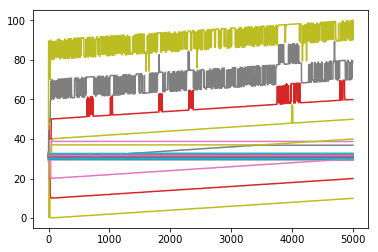

In [6]:
plt.plot(class_means)
a=1

In [7]:
class_prototypes.mean(axis=-1)
class_prototypes.std(axis=-1)

array([ 0.15746573,  0.17853865,  0.1888658 ,  0.18535791,  0.17957064,
        0.19035976,  0.1671918 ,  0.18674761,  0.19054151,  0.18393092,
        0.17970353,  0.19029878,  0.1678531 ,  0.19901662,  0.18998829,
        0.19685483,  0.1894186 ,  0.20859871,  0.19269667,  0.1990704 ,
        0.192939  ,  0.19631056,  0.1767003 ,  0.16404565,  0.18359928,
        0.19414694,  0.18398593,  0.15858193,  0.18457953,  0.18611129,
        0.16537989,  0.18468202,  0.18293283,  0.17767023,  0.1948095 ,
        0.21030504,  0.19447631,  0.17745405,  0.16817712,  0.17502231,
        0.1940878 ,  0.17449717,  0.17617938,  0.18893404,  0.18488907,
        0.17596693,  0.1943254 ,  0.15619375,  0.17680474,  0.19300315])

### Implement batch SOM
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.700.1701&rep=rep1&type=pdf

In [24]:
flags = dotdict({})
flags.cross_class_decay = 0.9
flags.cross_class_num_clusters = 64
batch_size = 32
num_features = 128
kernel_width = 0.1
sigma_0 = 1

class_prototypes = 0.1*np.random.uniform(size=(flags.cross_class_num_clusters, num_features))
som_grid = np.meshgrid(np.arange(np.sqrt(flags.cross_class_num_clusters)), np.arange(np.sqrt(flags.cross_class_num_clusters)))
som_grid = np.array(som_grid).reshape((2, -1)).transpose()
som_dist = np.sum(np.square(np.expand_dims(som_grid, -1) - som_grid.transpose()), axis=1)

n_steps = 2000
class_means = np.zeros((n_steps, flags.cross_class_num_clusters))
for i in range(n_steps):
    d_samples_np = 0/10 + 10*np.sin(2*np.pi*i/400) + \
        100*np.random.randint(0, 4, size=(batch_size,1)) + \
        1*np.random.normal(0, 1, size=(batch_size, num_features))
    
    sample_prototype_distances = -np.mean(
        np.square(np.expand_dims(d_samples_np, -1) - class_prototypes.transpose()), axis=1)
    
    bmu_idxs = np.argmax(sample_prototype_distances, axis=-1)
    
    sigma = sigma_0 * (1 - 0/n_steps) # / np.power(i+1, 0.1)
    h = np.exp(-som_dist/(2*sigma))
    h_cj_i = h[bmu_idxs]
    bmu_prototype_weights = h_cj_i / np.sum(h_cj_i, axis=0, keepdims=True)
    
    new_prototypes = np.matmul(bmu_prototype_weights.transpose(), d_samples_np)
    
    update_step = (1-flags.cross_class_decay) / np.power(i+1, 0.0)
    class_prototypes += update_step * (new_prototypes - class_prototypes)
    class_means[i] = class_prototypes.mean(axis=-1)
    
bmu_idxs

array([44, 13, 25, 44, 13,  0, 25, 44, 13, 13,  0, 44, 13,  0, 44, 44, 44,
        0, 13,  0, 13, 13, 13,  0,  0, 25, 32, 25, 13, 44, 32,  0])

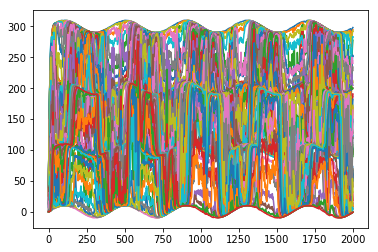

In [25]:
plt.plot(class_means)
a=1

In [39]:
flags = dotdict({})
flags.cross_class_decay = 0.9
flags.cross_class_num_clusters = 64
flags.cross_class_sigma_0 = 1.0
batch_size = 32
num_features = 128

features_modality1_np = np.random.normal(0, 1, size=(batch_size, num_features))
features_modality2_np = np.random.normal(0, 1, size=(batch_size, num_features))

tf.reset_default_graph()

with tf.Session() as sess:
    with tf.variable_scope("SOM", reuse=tf.AUTO_REUSE):
        
        class_prototypes = tf.get_variable(name='class_prototypes', 
                                           shape=(flags.cross_class_num_clusters, num_features), 
                                           dtype=tf.float32, trainable=False, regularizer=None,
                                           initializer=tf.initializers.random_uniform(maxval=1))
        
        som_grid = np.meshgrid(np.arange(np.sqrt(flags.cross_class_num_clusters)), 
                               np.arange(np.sqrt(flags.cross_class_num_clusters)))
        som_grid = np.array(som_grid).reshape((2, -1)).transpose()
        som_dist = np.sum(np.square(np.expand_dims(som_grid, -1) - som_grid.transpose()), axis=1)
        sigma = flags.cross_class_sigma_0
        H = np.exp(-som_dist/(2.0*sigma)).astype(np.float32)

        features_modality1 = tf.placeholder(shape=(batch_size, num_features), dtype=tf.float32)
        features_modality2 = tf.placeholder(shape=(batch_size, num_features), dtype=tf.float32)
        
        # Concatenate text and image modalities
        d_samples = tf.concat([features_modality1, features_modality2], axis=0)
        
        sample_prototype_distances = -tf.reduce_mean(tf.square(
            tf.expand_dims(d_samples, -1) - tf.transpose(class_prototypes)), axis=1)
        bmu_idxs = tf.argmax(sample_prototype_distances, axis=-1, output_type=tf.int32)
        
        h_cj_i = tf.gather(H, bmu_idxs)
        bmu_prototype_weights = h_cj_i / tf.reduce_sum(h_cj_i, axis=0, keepdims=True)
        
        new_prototypes = tf.matmul(bmu_prototype_weights, d_samples, transpose_a=True)
        update_step = (1-flags.cross_class_decay)
        
        class_prototypes_update_op = tf.assign(class_prototypes,
                                               class_prototypes + \
                                               update_step * (new_prototypes - class_prototypes))
        
#         with tf.control_dependencies([class_prototypes_update_op]):
        
        
        sess.run(tf.global_variables_initializer())
        
#         print("BMU indexes", bmu_idxs.eval())
#         print("BMUs unique", bmu_idxs_unique.eval())
#         print("BMU position in batch", bmu_idxs_position.eval())
#         print("BMU count", bmu_idxs_unique_count.eval())
#         print(bmu_inverse_weights.eval())

        print(tf.get_collection(tf.GraphKeys.UPDATE_OPS))
        
        n_steps = 2000
        class_means = np.zeros((n_steps, flags.cross_class_num_clusters))
        for i in range(n_steps):
            d_samples_np1 = 0/10 + 10*np.sin(2*np.pi*i/400) + \
                100*np.random.randint(0, 4, size=(batch_size,1)) + \
                1*np.random.normal(0, 1, size=(batch_size, num_features))
            
            d_samples_np2 = 0/10 + 10*np.sin(2*np.pi*i/400) + \
                100*np.random.randint(0, 4, size=(batch_size,1)) + \
                1*np.random.normal(0, 1, size=(batch_size, num_features))
            
#             with tf.control_dependencies(class_prototypes_update_op):
            class_prototypes_np = sess.run([class_prototypes_update_op], 
                                           {features_modality1: d_samples_np1, 
                                            features_modality2: d_samples_np2})[0]
    
            class_means[i] = class_prototypes_np.mean(axis=-1)
        
        
#         for i in range(10):
#             gaussian_zero_mean = np.random.randint(0, 2, size=(batch_size,1)) * np.random.normal(1, 0.1, size=(batch_size, num_features))
#             gaussian_unity_mean = np.random.randint(0, 2, size=(batch_size,1)) * np.random.normal(1, 0.1, size=(batch_size, num_features))
            
#             with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#                 class_prototypes_np, best_data_point_conditon_np, bmu_idxs_np = \
#                     sess.run([class_prototypes, best_data_point_conditon, bmu_idxs], 
#                          {features_modality1: gaussian_zero_mean, features_modality2: gaussian_unity_mean})
            
#             print(bmu_idxs_np)
            
#             class_prototypes_np, bmus_update_np = output
            
#         print(bmu_idxs)
#         print(bm_data_idxs)
#         print("BMU index", bmu_idxs.eval())
#         print("Data point of prototype", bm_data_idxs.eval())
#         print(tf.gather(bm_data_idxs, bmu_idxs).eval())
#         print(best_data_point_conditon.eval())
#         print(bmus_update.eval())
#         print(class_prototypes.eval())
        
#         class_prototypes_np = class_prototypes.eval()
#         bmus_update_np = bmus_update.eval()


[]


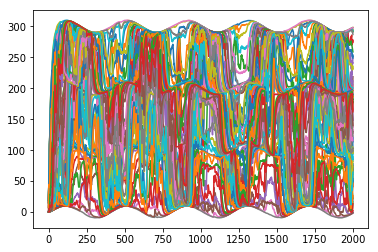

In [40]:
plt.plot(class_means)
a=1

In [134]:
from common.losses import get_som_loss

flags = dotdict({})
flags.cross_class_decay = 0.9
flags.cross_class_num_clusters = 1024
flags.cross_class_metric_scale = 100.0
flags.cross_class_sigma_0 = 1.0
batch_size = 32
num_features = 128

# features_modality1_np = np.random.normal(0, 1, size=(batch_size, num_features))
# features_modality2_np = np.random.normal(0, 1, size=(batch_size, num_features))

tf.reset_default_graph()
with tf.Session() as sess:
    features_modality1 = tf.placeholder(shape=(batch_size, num_features), dtype=tf.float32)
    features_modality2 = tf.placeholder(shape=(batch_size, num_features), dtype=tf.float32)

    class_loss = get_som_loss(features_modality1, features_modality2, flags)
    class_prototypes_tf = tf.get_default_graph().get_tensor_by_name("som_loss/SOM/class_prototypes:0")
    accuracy_tf = tf.get_default_graph().get_tensor_by_name("som_loss/accuracy/Mean:0")
    
    nan_check_tf = tf.get_default_graph().get_tensor_by_name("som_loss/SOM/transpose_2:0")

    sess.run(tf.global_variables_initializer())

    n_steps = 2000
    class_means = np.zeros((n_steps, flags.cross_class_num_clusters))
    class_loss_history = np.zeros((n_steps, ))
    accuracy__history = np.zeros((n_steps, ))
    for i in range(n_steps):
        classes_batch1 = 100*np.random.randint(0, 10, size=(batch_size,1))
        classes_batch2 = 100*np.random.randint(0, 10, size=(batch_size,1))
        d_samples_np1 = 0/10 + 50*np.sin(2*np.pi*i/400) + classes_batch1 + \
            1*np.random.normal(0, 1, size=(batch_size, num_features))

        d_samples_np2 = 0/10 + 50*np.sin(2*np.pi*i/400) + classes_batch1 + \
            1*np.random.normal(0, 1, size=(batch_size, num_features))        

        class_prototypes_np, class_loss_history[i], accuracy__history[i], nan_check = \
            sess.run([class_prototypes_tf, class_loss, accuracy_tf, nan_check_tf], 
                                       {features_modality1: d_samples_np1, 
                                        features_modality2: d_samples_np2})
        
        if np.any(np.isnan(nan_check)):
            print(np.any(np.isnan(nan_check)))

        class_means[i] = class_prototypes_np.mean(axis=-1)
                

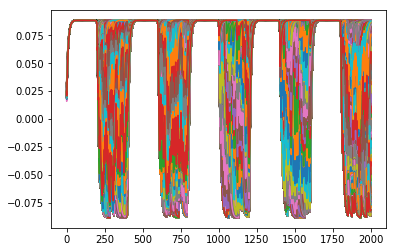

In [135]:
plt.plot(class_means)
a=1

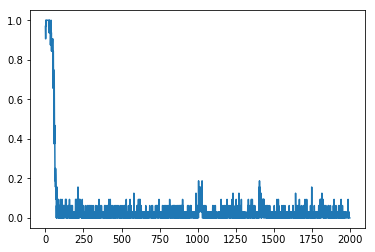

In [136]:
plt.plot(accuracy__history)

In [138]:
np.sum(np.sum(np.isnan(class_prototypes_np), axis=1))

0

In [108]:
class_prototypes_np[13]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32)